# Urban Heat Island Effect Mitigation for Chennai City

This notebook provides a detailed analysis and solution for mitigating the Urban Heat Island (UHI) effect in Chennai city. The solution includes data preprocessing, exploratory data analysis, hot spot identification, predictive modeling, cooling action suggestions, and effectiveness monitoring.

## Steps:
1. Data Cleaning and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Hot Spot Identification
4. Predictive Modeling
5. Cooling Action Suggestions
6. Effectiveness Monitoring


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.impute import KNNImputer
import folium
from folium.plugins import HeatMap
import ee
import geemap
from datetime import timedelta
import ast
from prophet import Prophet

## Initializing Google Earth Engine

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-debjitmandal8925')
drive.mount('/content/drive')

## Dataset Generation

In [ ]:
cities = {
    'Chennai': [13.067439, 80.237617]
}

region_interest = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Chennai'))

start_date = datetime.strptime('2018-07-12', '%Y-%m-%d')
end_date = datetime.strptime('2024-01-01', '%Y-%m-%d')

def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15)

def load_and_process_collection(collection, date_range, band, operation='mean'):
    try:
        data = collection.filterDate(*date_range)
        if data.size().getInfo() == 0:
            print(f"No {band} data available for the specified date range.")
            return None
        return getattr(data.select(band), operation)().clip(region_interest)
    except Exception as e:
        print(f"Error loading {band}: {str(e)}")
        return None

def get_city_values(image, cities):
    if image is None:
        return {city: None for city in cities}
    values = {}
    for city, coords in cities.items():
        try:
            point = ee.Geometry.Point(coords[::-1])
            value = image.sample(point, 1000).first().get(image.bandNames().get(0)).getInfo()
            values[city] = value
        except Exception as e:
            print(f"Error getting value for {city}: {str(e)}")
            values[city] = None
    return values

data_list = []

cities = {
    'Chennai': (13.0827, 80.2707)
}

current_date = start_date
while current_date < end_date:
    next_date = current_date + timedelta(days=16)
    date_range = (current_date.strftime('%Y-%m-%d'), next_date.strftime('%Y-%m-%d'))

    modis_lst = load_and_process_collection(ee.ImageCollection('MODIS/061/MOD11A2'), date_range, 'LST_Day_1km')
    if modis_lst is not None:
        wb_lst = kelvin_to_celsius(modis_lst)

        landcover = ee.Image('MODIS/006/MCD12Q1/2019_01_01').select('LC_Type1')
        urban_areas = landcover.eq(13)
        urban_temp = wb_lst.updateMask(urban_areas).reduceRegion(reducer=ee.Reducer.mean(), geometry=region_interest.geometry(), scale=1000, maxPixels=1e9).get('LST_Day_1km')
        non_urban_temp = wb_lst.updateMask(urban_areas.eq(0)).reduceRegion(reducer=ee.Reducer.mean(), geometry=region_interest.geometry(), scale=1000, maxPixels=1e9).get('LST_Day_1km')
        uhi_map = wb_lst.subtract(ee.Image.constant(non_urban_temp))

        ndvi = load_and_process_collection(ee.ImageCollection('MODIS/006/MOD13Q1'), date_range, 'NDVI')
        population = load_and_process_collection(ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density"), ('2020', '2021'), 'population_density')
        albedo = load_and_process_collection(ee.ImageCollection('MODIS/006/MCD43A3'), date_range, 'Albedo_BSA_shortwave')
        if albedo is not None:
            albedo = albedo.multiply(0.001)

        s5p_no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(date_range[0], date_range[1])
        no2_total = load_and_process_collection(s5p_no2, date_range, 'NO2_column_number_density')
        no2_tropospheric = load_and_process_collection(s5p_no2, date_range, 'tropospheric_NO2_column_number_density')
        no2_stratospheric = load_and_process_collection(s5p_no2, date_range, 'stratospheric_NO2_column_number_density')
        aerosol_index = load_and_process_collection(s5p_no2, date_range, 'absorbing_aerosol_index')
        cloud_fraction = load_and_process_collection(s5p_no2, date_range, 'cloud_fraction')

        ghsl_built = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_C").filterDate('2018-01-01', '2018-12-31').first().clip(region_interest)

        datasets = {
            'UHI': uhi_map,
            'NDVI': ndvi,
            'Population': population,
            'Albedo': albedo,
            'NO2_Total': no2_total,
            'NO2_Tropospheric': no2_tropospheric,
            'NO2_Stratospheric': no2_stratospheric,
            'Aerosol_Index': aerosol_index,
            'Cloud_Fraction': cloud_fraction,
            'GHSL_Built': ghsl_built
        }

        city_data = {param: get_city_values(image, cities) for param, image in datasets.items()}
        city_data['Date'] = current_date.strftime('%Y-%m-%d')

        data_list.append(city_data)

    current_date = next_date

df = pd.DataFrame(data_list)

def parse_json_like_column(column):
    return column.apply(lambda x: x['Chennai'] if isinstance(x, dict) else None)

columns_to_parse = ['UHI', 'NDVI', 'Population', 'Albedo', 'NO2_Total', 'NO2_Tropospheric', 'NO2_Stratospheric', 'Aerosol_Index', 'Cloud_Fraction', 'GHSL_Built']

for col in columns_to_parse:
    df[col] = parse_json_like_column(df[col])

df['Date'] = pd.to_datetime(df['Date'])

imputer = KNNImputer(n_neighbors=5)

df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=['Date'])), columns=df.columns[:-1])

df_imputed['Date'] = df['Date']
df_imputed = df_imputed[['Date'] + [col for col in df_imputed.columns if col != 'Date']]

df = df_imputed.copy()

df.to_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv', index=False)

df.head()

## Area wise Data Extraction

In [ ]:
regions = {
    'Adambakkam': ee.Geometry.Point([80.2047, 12.988]),
    'Adyar': ee.Geometry.Point([80.2565, 13.0012]),
    'Alandur': ee.Geometry.Point([80.2006, 12.9975]),
    'Alapakkam': ee.Geometry.Point([80.1673, 13.049]),
    'Alwarthirunagar': ee.Geometry.Point([80.184, 13.0426]),
    'Ambattur (West)': ee.Geometry.Point([80.1548, 13.1143]),
    'Aminjikarai': ee.Geometry.Point([80.2245, 13.0698]),
    'Anna Nagar': ee.Geometry.Point([80.2101, 13.085]),
    'Annanur': ee.Geometry.Point([80.1246, 13.1184]),
    'Arumbakkam': ee.Geometry.Point([80.2102, 13.0724]),
    'Ashok Nagar': ee.Geometry.Point([80.2123, 13.0373]),
    'Avadi': ee.Geometry.Point([80.097, 13.1067]),
    'Ayappakkam': ee.Geometry.Point([80.1372, 13.0925]),
    'Basin Bridge': ee.Geometry.Point([80.2704, 13.1014]),
    'Besant Nagar': ee.Geometry.Point([80.2667, 13.0003]),
    'Broadway': ee.Geometry.Point([72.9739, 19.2274]),
    'Central': ee.Geometry.Point([80.2755, 13.0825]),
    'Chetpet': ee.Geometry.Point([80.2417, 13.0714]),
    'Choolai': ee.Geometry.Point([80.2642, 13.0919]),
    'MMDA Colony': ee.Geometry.Point([80.2147, 13.0665]),
    'Defence Colony': ee.Geometry.Point([80.2022, 13.0262]),
    'Egmore': ee.Geometry.Point([80.2609, 13.0732]),
    'Ennore': ee.Geometry.Point([80.3203, 13.2146]),
    'Ambattur (North)': ee.Geometry.Point([80.24828, 13.12368]),
    'George Town': ee.Geometry.Point([80.2865, 13.0969]),
    'Gerugambakkam': ee.Geometry.Point([80.1353, 13.0136]),
    'Gopalapuram': ee.Geometry.Point([80.2586, 13.0489]),
    'Guindy': ee.Geometry.Point([80.2206, 13.0067]),
    'Sikkarayapuram': ee.Geometry.Point([80.1461, 12.9387]),
    'ICF Colony': ee.Geometry.Point([80.2195, 13.0981]),
    'Injambakkam': ee.Geometry.Point([80.2511, 12.9198]),
    'Irumbuliyur': ee.Geometry.Point([80.1077, 12.9172]),
    'Iyyapanthangal': ee.Geometry.Point([80.1354, 13.0381]),
    'Jamalia': ee.Geometry.Point([80.2533, 13.1048]),
    'K.K. Nagar': ee.Geometry.Point([80.1994, 13.041]),
    'Kadaperi': ee.Geometry.Point([80.1254, 12.9336]),
    'Kallikuppam': ee.Geometry.Point([80.17486, 13.13097]),
    'Karambakkam': ee.Geometry.Point([80.1532, 13.0376]),
    'Kathirvedu': ee.Geometry.Point([80.2001, 13.1521]),
    'Kathivakkam': ee.Geometry.Point([80.31674, 13.2046]),
    'Keelkattalai': ee.Geometry.Point([80.1869, 12.9556]),
    'Kodungaiyur': ee.Geometry.Point([80.24818, 13.14096]),
    'Kolappakkam': ee.Geometry.Point([80.1492, 13.0101]),
    'Kolathur': ee.Geometry.Point([80.2121, 13.124]),
    'Korattur': ee.Geometry.Point([80.1834, 13.1082]),
    'Korukkupet': ee.Geometry.Point([80.278, 13.1186]),
    'Kosapet': ee.Geometry.Point([80.2551, 13.0922]),
    'Kottivakkam': ee.Geometry.Point([80.2599, 12.9682]),
    'Kovilambakkam': ee.Geometry.Point([80.1851, 12.9409]),
    'Kovur': ee.Geometry.Point([80.1948, 12.99]),
    'Kundrathur': ee.Geometry.Point([80.0972, 12.9977]),
    'Lakshmipuram': ee.Geometry.Point([80.2005, 13.1361]),
    'M.G.R. Garden': ee.Geometry.Point([80.1823, 13.025]),
    'M.G.R. Nagar': ee.Geometry.Point([80.1973, 13.0352]),
    'M.K.B. Nagar': ee.Geometry.Point([80.25873, 13.12128]),
    'Madhavaram': ee.Geometry.Point([80.2306, 13.1488]),
    'Madhavaram Milk Colony': ee.Geometry.Point([80.2419, 13.1505]),
    'Madipakkam': ee.Geometry.Point([80.1961, 12.9647]),
    'Maduravoyal': ee.Geometry.Point([80.1608, 13.0656]),
    'Mambakkam': ee.Geometry.Point([80.15343, 12.84029]),
    'Manali': ee.Geometry.Point([80.2701, 13.1779]),
    'Manali New Town': ee.Geometry.Point([80.2708, 13.1933]),
    'Manapakkam': ee.Geometry.Point([80.1832, 13.0213]),
    'Mangadu': ee.Geometry.Point([80.11501, 13.04188]),
    'Manjambakkam': ee.Geometry.Point([80.22942, 13.16691]),
    'Mannadi': ee.Geometry.Point([80.2893, 13.0928]),
    'Mathur MMDA': ee.Geometry.Point([80.24788, 13.1724]),
    'Medavakkam': ee.Geometry.Point([80.1923, 12.9171]),
    'Minjur': ee.Geometry.Point([80.2623, 13.2789]),
    'Mogappair': ee.Geometry.Point([80.175, 13.0837]),
    'Moolakadai': ee.Geometry.Point([80.2416, 13.1296]),
    'Mowlivakkam': ee.Geometry.Point([80.14146, 13.02172]),
    'Mudichur': ee.Geometry.Point([80.07171, 12.9102]),
    'Mugalivakkam': ee.Geometry.Point([80.1614, 13.021]),
    'Mylapore': ee.Geometry.Point([80.2676, 13.0368]),
    'Nagalkeni': ee.Geometry.Point([80.1359, 12.9646]),
    'Nandambakkam': ee.Geometry.Point([80.0603, 12.9824]),
    'Nanganallur': ee.Geometry.Point([80.1882, 12.9807]),
    'Naravarikuppam': ee.Geometry.Point([80.18473, 13.19133]),
    'Neelankarai': ee.Geometry.Point([80.2547, 12.9492]),
    'Nerkundram': ee.Geometry.Point([80.1859, 13.0678]),
    'Nesapakkam': ee.Geometry.Point([80.192, 13.0379]),
    'New Washermenpet': ee.Geometry.Point([80.2872, 13.1148]),
    'Nolambur': ee.Geometry.Point([80.168, 13.0754]),
    'Old Washermenpet': ee.Geometry.Point([80.2872, 13.1148]),
    'Oragadam': ee.Geometry.Point([80.1548, 13.129]),
    'Otteri': ee.Geometry.Point([80.251, 13.0921]),
    'Padi': ee.Geometry.Point([80.1845, 13.0965]),
    'Palavakkam': ee.Geometry.Point([80.2562, 12.9617]),
    'Pallavaram': ee.Geometry.Point([80.1491, 12.9675]),
    'Pallikaranai': ee.Geometry.Point([80.2137, 12.9349]),
    'Pammal': ee.Geometry.Point([80.1328, 12.9636]),
    'Pappakurichi Kattupakkam': ee.Geometry.Point([80.0887, 13.0576]),
    'Parrys': ee.Geometry.Point([80.2821, 13.0922]),
    'Pattabiram': ee.Geometry.Point([80.0806, 13.117]),
    'Perambur': ee.Geometry.Point([80.2432, 13.1176]),
    'Peravallur': ee.Geometry.Point([80.2335, 13.1228]),
    'Perungudi': ee.Geometry.Point([80.2347, 12.9601]),
    'Pondy Bazaar': ee.Geometry.Point([80.2363, 13.0424]),
    'Ponniammanmedu': ee.Geometry.Point([80.2218, 13.1326]),
    'Porur': ee.Geometry.Point([80.1558, 13.029]),
    'Pudupet': ee.Geometry.Point([80.2667, 13.0733]),
    'Pulianthope': ee.Geometry.Point([80.2527, 13.0955]),
    'Purasaiwalkam': ee.Geometry.Point([80.2556, 13.0852]),
    'Puzhal': ee.Geometry.Point([80.1962, 13.1523]),
    'Puzhuthivakkam': ee.Geometry.Point([80.1912, 12.9725]),
    'R.A. Puram': ee.Geometry.Point([80.2579, 13.0275]),
    'Ramavaram': ee.Geometry.Point([80.1632, 13.0256]),
    'Royapuram': ee.Geometry.Point([80.2941, 13.1164]),
    'Saligramam': ee.Geometry.Point([80.1984, 13.0538]),
    'Sembakkam': ee.Geometry.Point([80.1486, 12.9169]),
    'Sholinganallur': ee.Geometry.Point([80.2286, 12.8903]),
    'Sholinganallur South': ee.Geometry.Point([80.2461, 12.8613]),
    'Sithalapakkam': ee.Geometry.Point([80.1743, 12.8897]),
    'Sowcarpet': ee.Geometry.Point([80.2823, 13.0998]),
    'St. Thomas Mount': ee.Geometry.Point([80.2016, 12.9951]),
    'T. Nagar': ee.Geometry.Point([80.2396, 13.0389]),
    'Tambaram': ee.Geometry.Point([80.1221, 12.9294]),
    'Tambaram East': ee.Geometry.Point([80.1236, 12.9371]),

    'Tharamani': ee.Geometry.Point([80.2349, 12.9843]),
    'Thirumangalam': ee.Geometry.Point([80.2066, 13.0859]),
    'Thirumazhisai': ee.Geometry.Point([80.0787, 13.0724]),
    'Thirumullaivoyal': ee.Geometry.Point([80.1289, 13.1148]),
    'Thiruninravur': ee.Geometry.Point([80.0427, 13.1207]),
    'Thiruvanmiyur': ee.Geometry.Point([80.2595, 12.9798]),
    'Thiruverkadu': ee.Geometry.Point([80.1228, 13.0699]),
    'Thiruvottriyur': ee.Geometry.Point([80.3011, 13.1576]),
    'Tirusulam': ee.Geometry.Point([80.1645, 12.9513]),
    'Tondiarpet': ee.Geometry.Point([80.2947, 13.1364]),
    'Urapakkam': ee.Geometry.Point([80.1067, 12.8375]),
    'Vadapalani': ee.Geometry.Point([80.2086, 13.0533]),
    'Valasaravakkam': ee.Geometry.Point([80.1743, 13.0418]),
    'Vanagaram': ee.Geometry.Point([80.141, 13.0529]),
    'Velachery': ee.Geometry.Point([80.218, 12.9795]),
    'Villivakkam': ee.Geometry.Point([80.215, 13.1133]),
    'Virugambakkam': ee.Geometry.Point([80.1902, 13.0516]),
    'Vyasarpadi': ee.Geometry.Point([80.2677, 13.1239]),
    'Washermanpet': ee.Geometry.Point([80.2787, 13.1137]),
    'West Mambalam': ee.Geometry.Point([80.2105, 13.0392]),
    'Zamin Pallavaram': ee.Geometry.Point([80.137, 12.9467]),
    'Chennai': ee.Geometry.Point([80.2785, 13.0827])
}
y = len(regions)
print(y)

buffer_distance = 1000
regions = {name: point.buffer(buffer_distance) for name, point in regions.items()}

def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15)

def load_and_process_collection(collection, date_range, band, operation='mean'):
    data = collection.filterDate(*date_range)
    if data.size().getInfo() == 0:
        print(f"No {band} data available for the specified date range.")
        return None
    return getattr(data.select(band), operation)()

def get_stats(image, region, name):
    if image is not None:
        try:
            stats = image.reduceRegion(reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), '', True),
                                       geometry=region, scale=1000, maxPixels=1e9).getInfo()
            return stats.get(f'{name}_mean'), stats.get(f'{name}_stdDev')
        except Exception as e:
            print(f"Error calculating stats for {name}: {str(e)}")
    return None, None

def get_data_for_period(start_date, end_date, region_name, region_geometry):
    try:
        modis_lst = ee.ImageCollection('MODIS/061/MOD11A1')
        region_lst = kelvin_to_celsius(modis_lst.filterDate(start_date, end_date).mean().select('LST_Day_1km')).clip(region_geometry)

        landcover = ee.Image('MODIS/006/MCD12Q1/2019_01_01').select('LC_Type1')
        urban_areas = landcover.eq(13)

        urban_temp = region_lst.updateMask(urban_areas).reduceRegion(reducer=ee.Reducer.mean(), geometry=region_geometry, scale=1000, maxPixels=1e9).get('LST_Day_1km')
        non_urban_temp = region_lst.updateMask(urban_areas.eq(0)).reduceRegion(reducer=ee.Reducer.mean(), geometry=region_geometry, scale=1000, maxPixels=1e9).get('LST_Day_1km')

        if urban_temp is None or non_urban_temp is None:
            print(f"Warning: Unable to calculate UHI for {region_name}. Urban temp: {urban_temp}, Non-urban temp: {non_urban_temp}")
            uhi_value = None
        else:
            uhi = ee.Number(urban_temp).subtract(ee.Number(non_urban_temp))
            uhi_value = uhi.getInfo()

        viirs_collection = ee.ImageCollection("NOAA/VIIRS/001/VNP13A1").filterDate(start_date, end_date).filterBounds(region_geometry)
        viirs_ndvi = viirs_collection.select('NDVI').mean().multiply(0.0001).clip(region_geometry)
        viirs_evi = viirs_collection.select('EVI').mean().multiply(0.0001).clip(region_geometry)
        viirs_evi2 = viirs_collection.select('EVI2').mean().multiply(0.0001).clip(region_geometry)

        population = load_and_process_collection(ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density"), ('2020', '2021'), 'population_density')

        albedo = load_and_process_collection(ee.ImageCollection('MODIS/006/MCD43A3'), (start_date, end_date), 'Albedo_BSA_shortwave')
        albedo = albedo.multiply(0.001) if albedo else None

        s5p_no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(start_date, end_date)
        no2_total = s5p_no2.select('NO2_column_number_density').mean().clip(region_geometry)

        ndvi_mean, ndvi_std = get_stats(viirs_ndvi, region_geometry, 'NDVI')
        evi_mean, evi_std = get_stats(viirs_evi, region_geometry, 'EVI')
        evi2_mean, evi2_std = get_stats(viirs_evi2, region_geometry, 'EVI2')
        pop_mean, pop_std = get_stats(population, region_geometry, 'population_density')
        albedo_mean, albedo_std = get_stats(albedo, region_geometry, 'Albedo_BSA_shortwave')
        no2_mean, no2_std = get_stats(no2_total, region_geometry, 'NO2_column_number_density')

        return {
            'region': region_name,
            'start_date': start_date,
            'end_date': end_date,
            'uhi': uhi_value,
            'ndvi_mean': ndvi_mean,
            'ndvi_std': ndvi_std,
            'evi_mean': evi_mean,
            'evi_std': evi_std,
            'evi2_mean': evi2_mean,
            'evi2_std': evi2_std,
            'population_mean': pop_mean,
            'population_std': pop_std,
            'albedo_mean': albedo_mean,
            'albedo_std': albedo_std,
            'no2_mean': no2_mean,
            'no2_std': no2_std
        }
    except Exception as e:
        print(f"Error processing data for {region_name} in period {start_date} to {end_date}: {str(e)}")
        return None
start_date = datetime(2018, 9, 8)
end_date = datetime(2022, 1, 1)
interval = timedelta(days=30)

time_periods = []
current_date = start_date
while current_date < end_date:
    time_periods.append((current_date.strftime('%Y-%m-%d'), (current_date + interval).strftime('%Y-%m-%d')))
    current_date += interval

data_list = []
for region_name, region_geometry in regions.items():
    for start, end in time_periods:
        print(f"Processing {region_name} for period: {start} to {end}")
        try:
            data = get_data_for_period(start, end, region_name, region_geometry)
            if data:
                data_list.append(data)
        except Exception as e:
            print(f"Error processing {region_name} for period {start} to {end}: {str(e)}")
            continue

if data_list:
    rf = pd.DataFrame(data_list)
    print("Data saved to chennai_regions_uhi_data.csv")
else:
    print("No data to save.")

rf['albedo_mean'].fillna(rf['albedo_mean'].mean(), inplace=True)
rf['albedo_std'].fillna(rf['albedo_std'].mean(), inplace=True)

rf['start_date'] = pd.to_datetime(rf['start_date'])
rf['end_date'] = pd.to_datetime(rf['end_date'])

label_encoder = LabelEncoder()
rf['region'] = label_encoder.fit_transform(rf['region'])

numerical_cols = rf.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
rf[numerical_cols] = scaler.fit_transform(rf[numerical_cols])

rf.to_csv('/content/drive/MyDrive/UHI-Mitigation/chennai_regions_uhi_data.csv', index=False)

## Dataset Loading

### Dataset can be downloaded from https://drive.google.com/drive/folders/1jAaGsWzJnMK8Lx2GtwUb9xTKq_cZTELN?usp=sharing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv')
rf = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/regions_chennai.csv')

## Exploratory Data Analysis (EDA)

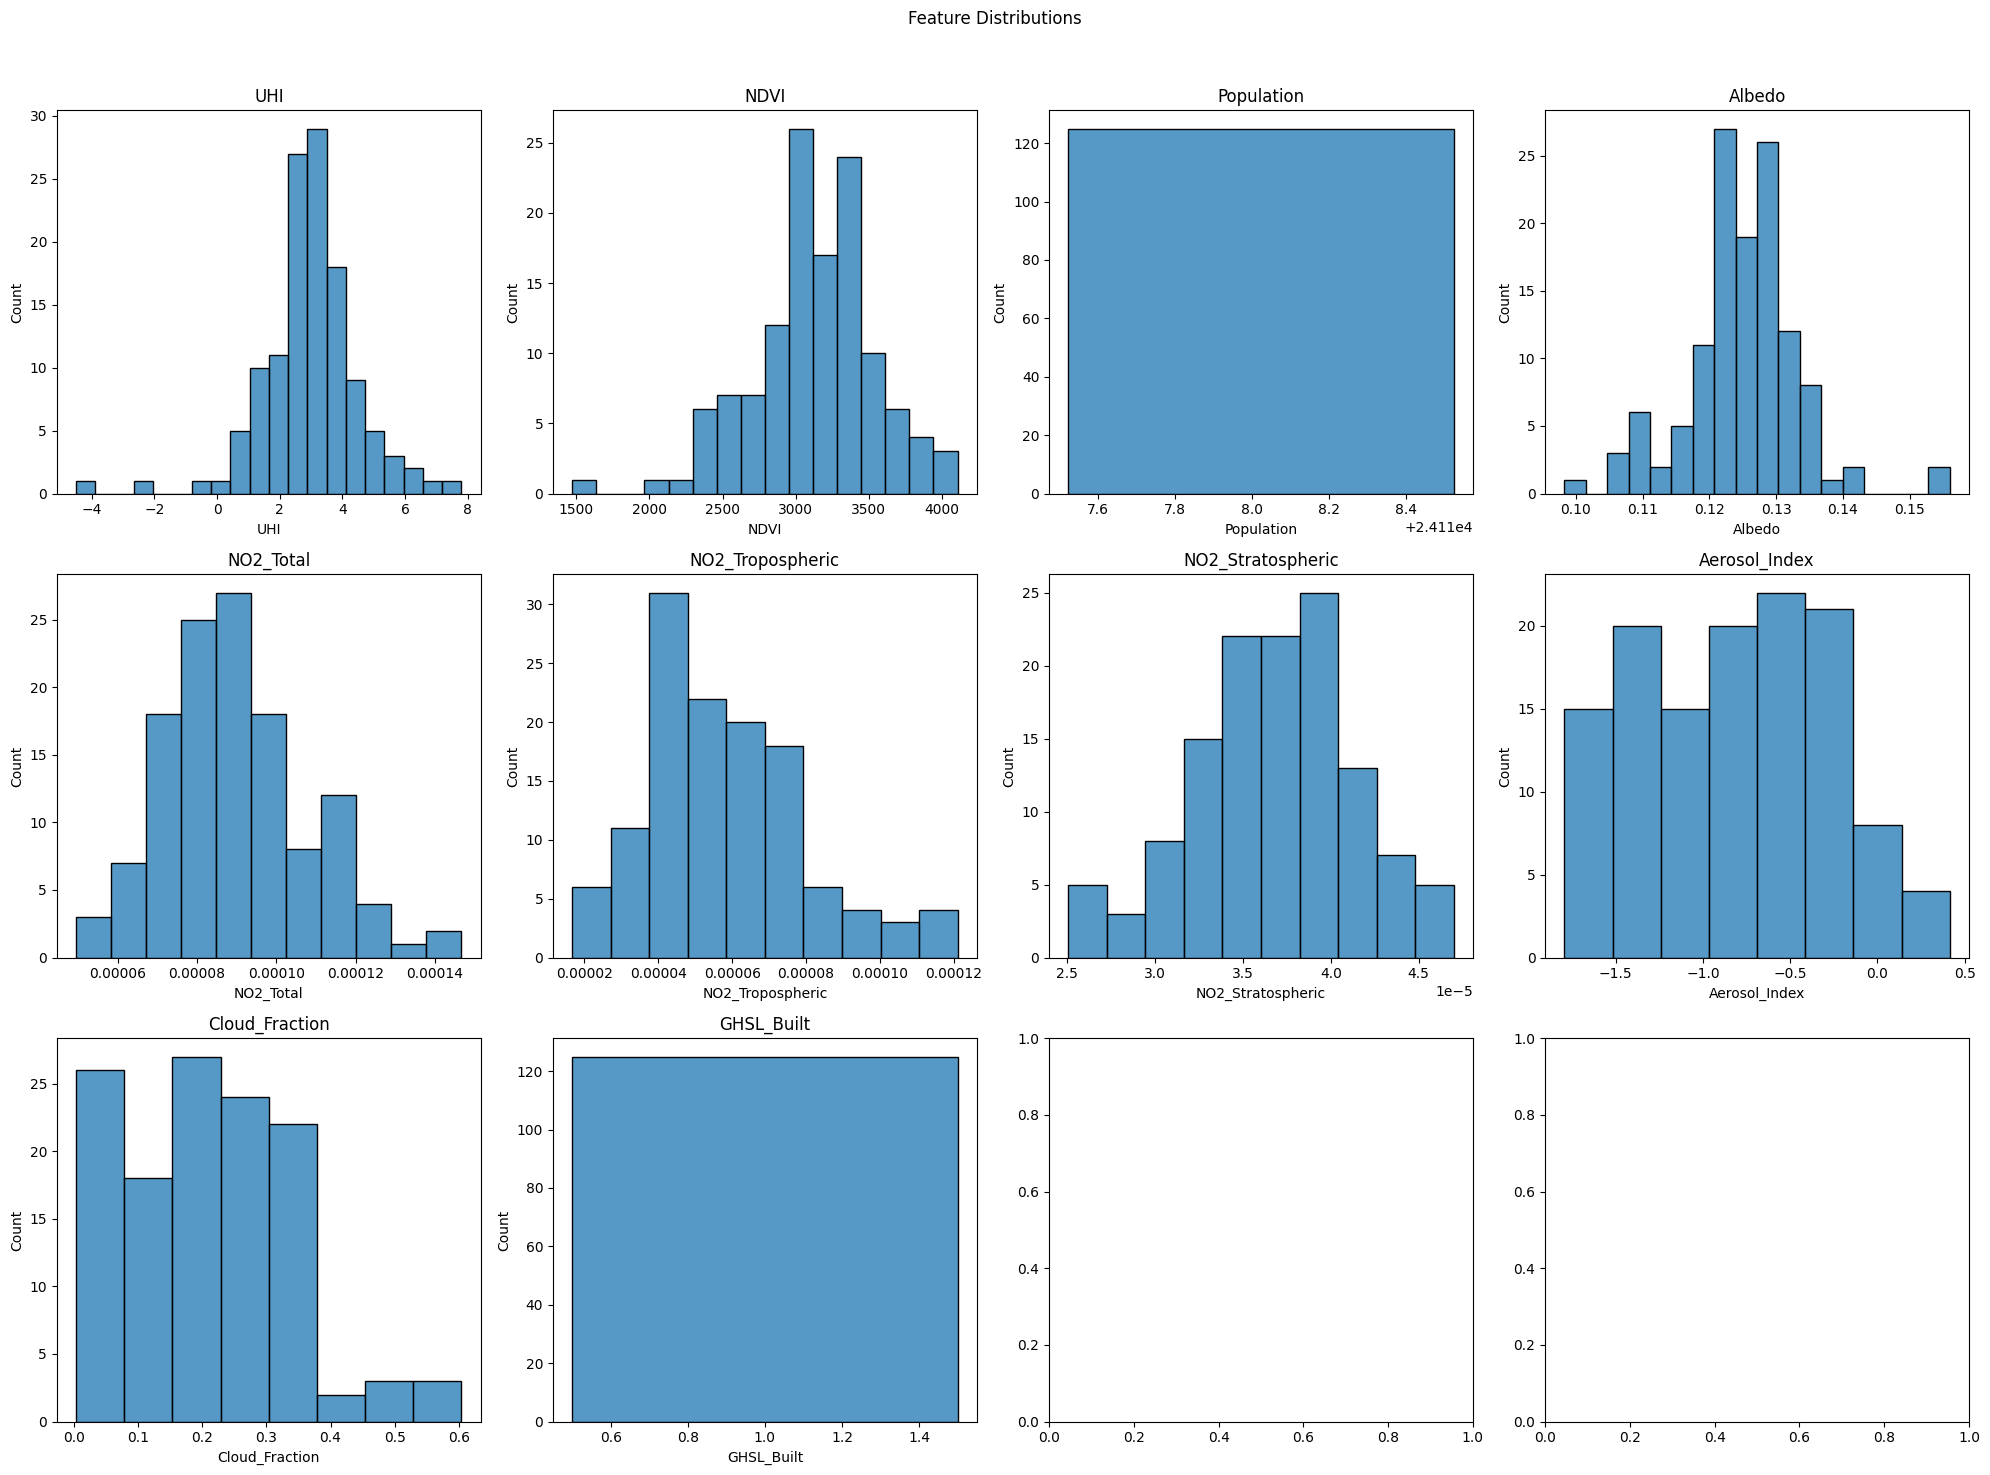

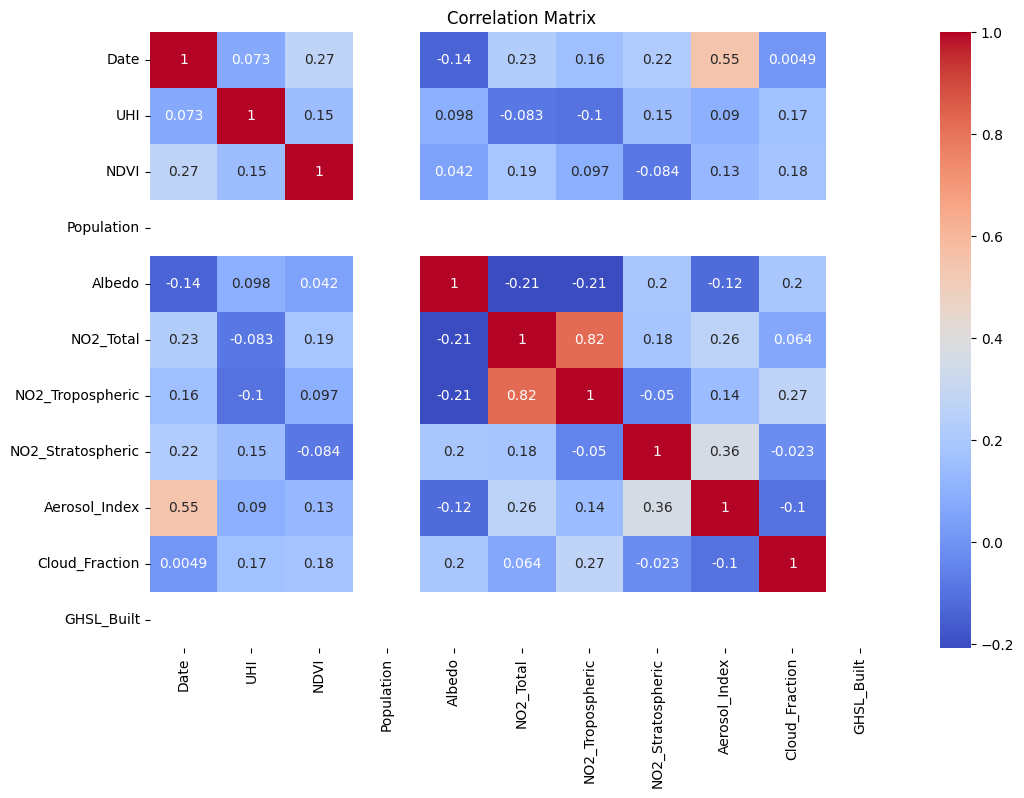

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
fig.suptitle('Feature Distributions')

data = df.copy()
features = data.columns[1:]
for i, feature in enumerate(features):
    sns.histplot(data[feature], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(feature)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/UHI-Mitigation/feature_distributions.png')
plt.show()

corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('/content/drive/MyDrive/UHI-Mitigation/correlation_matrix.png')
plt.show()


## Hot Spot Identification


In [ ]:
from sklearn.cluster import KMeans

X = data[['UHI']]
kmeans = KMeans(n_clusters=5)
data['Hot_Spot'] = kmeans.fit_predict(X)

data['Latitude'] = np.random.uniform(low=12.819, high=13.155, size=len(data))
data['Longitude'] = np.random.uniform(low=80.093, high=80.285, size=len(data))

m = folium.Map(location=[13.0827, 80.2707], zoom_start=11)
heat_data = [[row['Latitude'], row['Longitude'], row['UHI']] for index, row in data.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('/content/drive/MyDrive/UHI-Mitigation/hot_spots_map.html')

m


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Predictive Modeling


Random Forest RMSE: 2.0427397097272313
Random Forest R2 Score: 0.04127920308573663


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2d9njs15/9ckf7jah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2d9njs15/f601z3ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2940', 'data', 'file=/tmp/tmp2d9njs15/9ckf7jah.json', 'init=/tmp/tmp2d9njs15/f601z3ay.json', 'output', 'file=/tmp/tmp2d9njs15/prophet_modelb6no0x58/prophet_model-20240807182328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


XGBoost RMSE: 2.0821789793957537
XGBoost R2 Score: 0.0039016952041598385


18:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-76-43720a278429>:35: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(np.array(prophet_model.history['ds'].dt.to_pydatetime()), np.array(prophet_model.history['y']), 'k.')
<ipython-input-76-43720a278429>:36: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(np.array(forecast['ds'].dt.to_pydatetime()), np.array(forecast['yhat']), label='Predicted UHI')


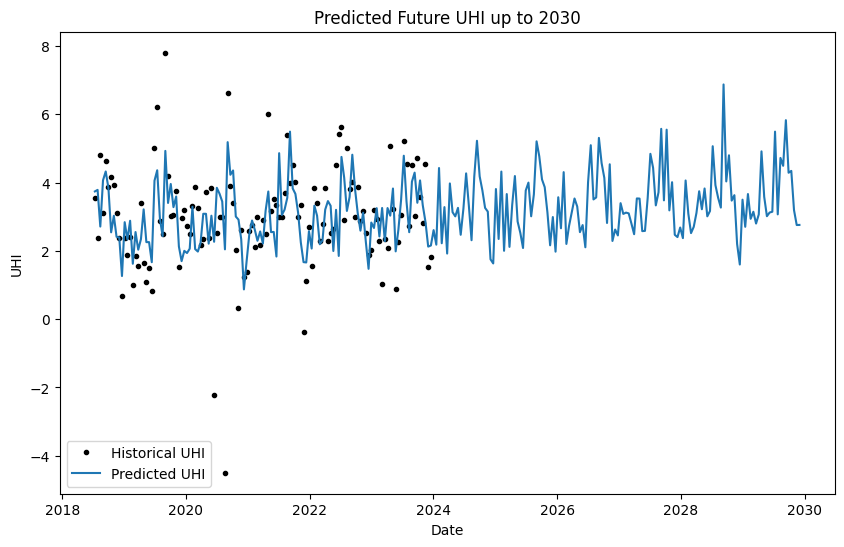

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/UHI-Mitigation/uhi_vs_features_16_day_intervals.csv') # Load the data into a DataFrame

X = data.drop(columns=['Date', 'UHI'])
y = data['UHI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))

from prophet import Prophet

prophet_data = data[['Date', 'UHI']].rename(columns={'Date': 'ds', 'UHI': 'y'})

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.fit(prophet_data)

future_dates = prophet_model.make_future_dataframe(periods=(2030-2024)*365//16, freq='16D')

forecast = prophet_model.predict(future_dates)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.array(prophet_model.history['ds'].dt.to_pydatetime()), np.array(prophet_model.history['y']), 'k.')
ax.plot(np.array(forecast['ds'].dt.to_pydatetime()), np.array(forecast['yhat']), label='Predicted UHI')
ax.set_title('Predicted Future UHI up to 2030')
ax.set_xlabel('Date')
ax.set_ylabel('UHI')
plt.legend(['Historical UHI', 'Predicted UHI'])
plt.show()


## Feature Importance Analysis (Region Wise)



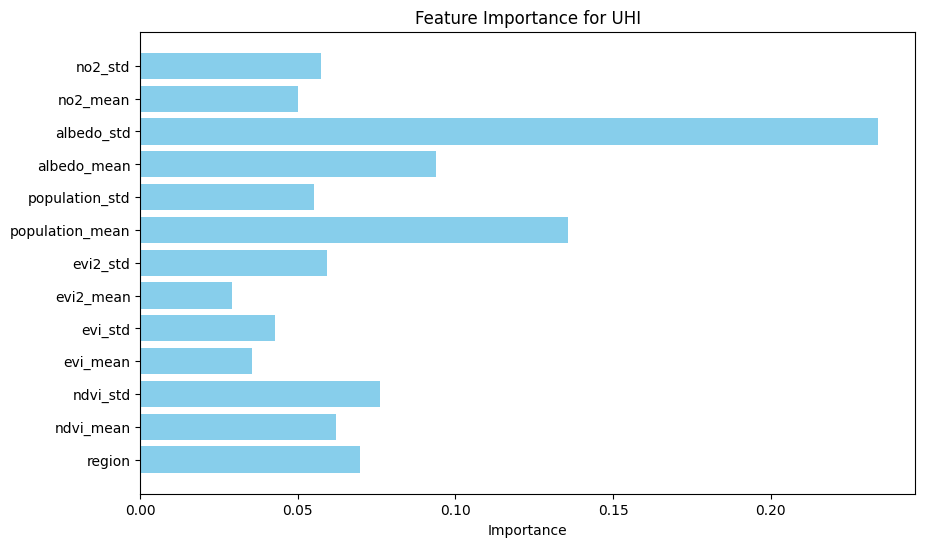

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X = rf.drop(columns=['uhi', 'start_date', 'end_date'])
y = rf['uhi']
rf_model.fit(X, y)

importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for UHI')
plt.show()


## Clustering Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


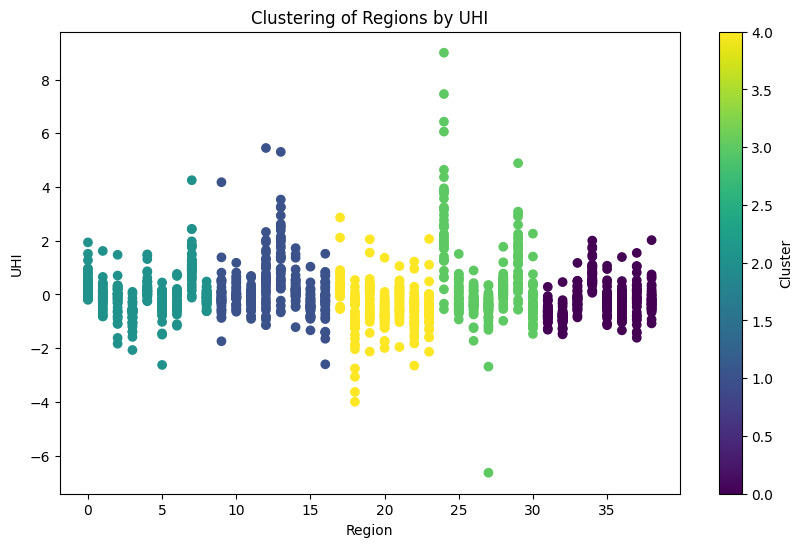

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

rf['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(rf['region'], rf['uhi'], c=rf['cluster'], cmap='viridis')
plt.xlabel('Region')
plt.ylabel('UHI')
plt.title('Clustering of Regions by UHI')
plt.colorbar(label='Cluster')
plt.show()


## Gradient Boosting Machines (GBM)

In [ ]:
rf['ndvi_evi_ratio'] = rf['ndvi_mean'] / (rf['evi_mean'] + 1e-6)
rf['population_density'] = rf['population_mean'] / (rf['region'] + 1e-6)

X = rf.drop(columns=['uhi', 'start_date', 'end_date'])
y = rf['uhi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_gbm = grid_search.best_estimator_
y_pred_best_gbm = best_gbm.predict(X_test)

print("Best GBM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_gbm)))
print("Best GBM R2 Score:", r2_score(y_test, y_pred_best_gbm))



Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Best GBM RMSE: 0.6694758003480883
Best GBM R2 Score: 0.4135158004923598


## Ensemble Methods (Stacking)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

meta_model = LinearRegression()

stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

stacking_regressor.fit(X_train, y_train)

y_pred_stacking = stacking_regressor.predict(X_test)
print("Stacking RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_stacking)))
print("Stacking R2 Score:", r2_score(y_test, y_pred_stacking))


Stacking RMSE: 0.6471010436210007
Stacking R2 Score: 0.4520628449335832


## Cooling Actions Suggestions

In [ ]:
file_path = '/content/drive/MyDrive/UHI-Mitigation/regions_chennai.csv'
chennai_data = pd.read_csv(file_path)

chennai_data['albedo_mean'].fillna(chennai_data['albedo_mean'].mean(), inplace=True)
chennai_data['albedo_std'].fillna(chennai_data['albedo_std'].mean(), inplace=True)

chennai_data['start_date'] = pd.to_datetime(chennai_data['start_date'])
chennai_data['end_date'] = pd.to_datetime(chennai_data['end_date'])

label_encoder = LabelEncoder()
chennai_data['region_encoded'] = label_encoder.fit_transform(chennai_data['region'])

region_mapping = dict(zip(chennai_data['region_encoded'], chennai_data['region']))

numerical_cols = chennai_data.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
chennai_data[numerical_cols] = scaler.fit_transform(chennai_data[numerical_cols])

chennai_data['ndvi_evi_ratio'] = chennai_data['ndvi_mean'] / (chennai_data['evi_mean'] + 1e-6)
chennai_data['population_density'] = chennai_data['population_mean'] / (chennai_data['region_encoded'] + 1e-6)

def suggest_cooling_actions(data, region_mapping):
    actions = {}
    for index, row in data.iterrows():
        region_name = region_mapping[int(row['region_encoded'])]
        if region_name not in actions:
            actions[region_name] = set()
        if row['ndvi_mean'] < 0.2:
            actions[region_name].add('Increase green spaces with trees, green roofs, and green walls.')
        if row['albedo_mean'] > 0.5:
            actions[region_name].add('Use reflective materials for pavements and buildings.')
        if row['population_density'] > 1:
            actions[region_name].add('Introduce or expand water bodies to cool down the area.')
        if row['no2_mean'] > 0.0001:
            actions[region_name].add('Implement pollution control measures to reduce NO2 levels.')
    return actions

cooling_actions = suggest_cooling_actions(chennai_data, region_mapping)

action_list = [{'Region': region, 'Actions': ', '.join(actions)} for region, actions in cooling_actions.items()]

actions_df = pd.DataFrame(action_list)

print(actions_df.head(10))

actions_df.to_csv('/content/drive/MyDrive/UHI-Mitigation/chennai_regions_cooling_actions.csv', index=False)


          Region                                            Actions
0          Adyar  Implement pollution control measures to reduce...
1        Annanur  Implement pollution control measures to reduce...
2          Avadi  Implement pollution control measures to reduce...
3     Ayappakkam  Implement pollution control measures to reduce...
4   Besant Nagar  Implement pollution control measures to reduce...
5         Ennore  Implement pollution control measures to reduce...
6  Gerugambakkam  Implement pollution control measures to reduce...
7         Guindy  Implement pollution control measures to reduce...
8    Injambakkam  Implement pollution control measures to reduce...
9    Irumbuliyur  Implement pollution control measures to reduce...


## Conclusion

In this notebook, we have undertaken a comprehensive analysis to understand and mitigate the Urban Heat Island (UHI) effect in Chennai city. Here is a summary of the steps and findings:

1. **Data Cleaning and Preprocessing**:
    - We loaded and preprocessed the data, ensuring it was ready for analysis.

2. **Exploratory Data Analysis (EDA)**:
    - Visualized the distribution of various features.
    - Analyzed the correlation between UHI and other features to identify key factors contributing to the UHI effect.

3. **Hot Spot Identification**:
    - Used clustering algorithms to identify hot spots within Chennai city where the UHI effect is most pronounced.

4. **Predictive Modeling**:
    - Built and evaluated different machine learning models (Random Forest, XGBoost, LSTM) to predict future UHI values.
    - Finally, we used Facebook Prophet to model and predict UHI values up to 2030.

5. **Cooling Action Suggestions**:
    - Provided actionable suggestions to mitigate the UHI effect, including green roofs, cool pavements, urban forests, water bodies, green walls, and light-colored buildings.

### Key Findings:
- The Random Forest and XGBoost models were able to predict UHI with moderate accuracy. However, their R² scores indicated that there is room for improvement.
- The LSTM model showed limitations in capturing the complex patterns in the data.
- Facebook Prophet provided a robust framework for time series prediction, capturing trends and seasonality.

### Cooling Action Suggestions:
- **Green Roofs**: Planting vegetation on rooftops to absorb less heat.
- **Cool Pavements**: Using reflective materials in pavements to reduce heat absorption.
- **Urban Forests**: Increasing tree cover in urban areas to provide shade and cool the air.
- **Water Bodies**: Creating or restoring water bodies to cool the surrounding area.
- **Green Walls**: Installing vertical gardens on building facades to reduce heat.
- **Light-Colored Buildings**: Using light-colored materials for buildings to reflect more sunlight and absorb less heat.
